<a href="https://colab.research.google.com/github/comparativechrono/nanopore-methylation/blob/main/PAC2_methylation_calling_from_BAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using modbam2bed to generate methylation bed files

# Methylation analysis on nanopore reads


To perform this work you need to use the GRCz11 version of the zebrafish genome. This can be imported from Enzembl via the FTP site.

In [ ]:
# Get Danio rerio assembly from Ensembl
! wget http://ftp.ensembl.org/pub/release-106/fasta/danio_rerio/dna/Danio_rerio.GRCz11.dna.primary_assembly.fa.gz
! gunzip Danio_rerio.GRCz11.dna.primary_assembly.fa.gz


# Install analysis tools
To run the analysis, various tools are required, which can be installed using
Miniconda.
Miniconda, mamba, samtools and modbam2bed will be installed. This notebook is formatted for running on colab. You may not need to install mamba if on your own system with a working conda distribution.


In [ ]:
# Miniconda
! wget https://repo.anaconda.com/miniconda/Miniconda3-py39_4.12.0-Linux-x86_64.sh
! chmod +x Miniconda3-py39_4.12.0-Linux-x86_64.sh
! bash ./Miniconda3-py39_4.12.0-Linux-x86_64.sh -b -f -p /usr/local
# mamba
! conda install -c conda-forge mamba -y
# samtools
! conda install -c bioconda samtools -y
# modbam2bed (in new conda environment)
! mamba create -n modbam2bed -c bioconda -c conda-forge -c epi2melabs modbam2bed -y

In [ ]:
## Pull in the modified bam files from Dropbox
#Suggest doing one a time as they are ~5 GB each
#ZT9 x2 samples
! wget -O ZT9_1.bam "https://www.dropbox.com/scl/fi/q3a5529qe8vkhb5rbr6br/ZT9_1.bam?rlkey=6aiegflyrxuvdogdsm0qzo52v&dl=1"
! wget -O ZT9_2.bam "https://www.dropbox.com/scl/fi/xoia8fuvsysx649kptn74/ZT9_2.bam?rlkey=dkg2ji3368fkgg3luwhc83gkm&dl=1"

#ZT21 x2 samples
! wget -O ZT21_1.bam "https://www.dropbox.com/scl/fi/unqn33jmk4x6lrvbr12cg/ZT21_1.bam?rlkey=7tuzptaj1gnbzme4kmzz8r2l4&dl=1"
! wget -O ZT21_2.bam "https://www.dropbox.com/scl/fi/jtho5o1uqm3xz5e5xop51/ZT21_2.bam?rlkey=dpopimtpugnb31yrsvdnuxsh9&dl=1"

In [ ]:
## Index the combined BAM file
! samtools index ZT9_1.bam
! samtools index ZT9_2.bam
! samtools index ZT21_1.bam
! samtools index ZT21_2.bam

# modbam2bed
Use modbam2bed to convert modified base data from nanopore sequencing into
bedMethyl files similar to those outputted from bisulfite sequencing.
These can then be visualised using software such as IGV. To do so,
conversion to BEDGRAPH files (which have fewer columns) may be more advantageous.


The code cells below are formatted as bash scripts, simply because the colab interface I have written it on struggles with conda environments. Once you have installed modbam2bed on your system, you should just be able to run the command

In [ ]:
%%bash
#this line only necessary in colab notebook
source activate modbam2bed
# modbam2bed command for 5mC
modbam2bed -e -m 5mC -r 2:52,020,049-52,022,849 Danio_rerio.GRCz11.dna.primary_assembly.fa ZT9_1.bam > ZT9_1_5mc.bed
# convert the BED file to a BEDGRAPH file for easier visualisation in IGV
awk 'BEGIN{OFS="\t"} {$4=$11; NF=4; print}' ZT9_1_5mc.bed > ZT9_1_5mc.bedgraph

Pull out the hemi-methylation as well
`modbam2bed` with the `-m 5hmc flag`

In [ ]:
%%bash
source activate modbam2bed
modbam2bed -e -m 5hmC -r 2:52,020,049-52,022,849 Danio_rerio.GRCz11.dna.primary_assembly.fa ZT9_1.bam > ZT9_1_5hmc.bed
# convert the BED file to a BEDGRAPH file for easier visualisation in IGV
awk 'BEGIN{OFS="\t"} {$4=$11; NF=4; print}' ZT9_1_5hmc.bed > ZT9_1_5hmc.bedgraph

To compare samples there are a variety of approached. The bedgraphs can be uploaded to IGV, to give a genomic context. This is the best approach. Alterantively in python you can make plots of whatever you like e.g make a heatmap. Column 11 of the bed file contains the methyation as a %.

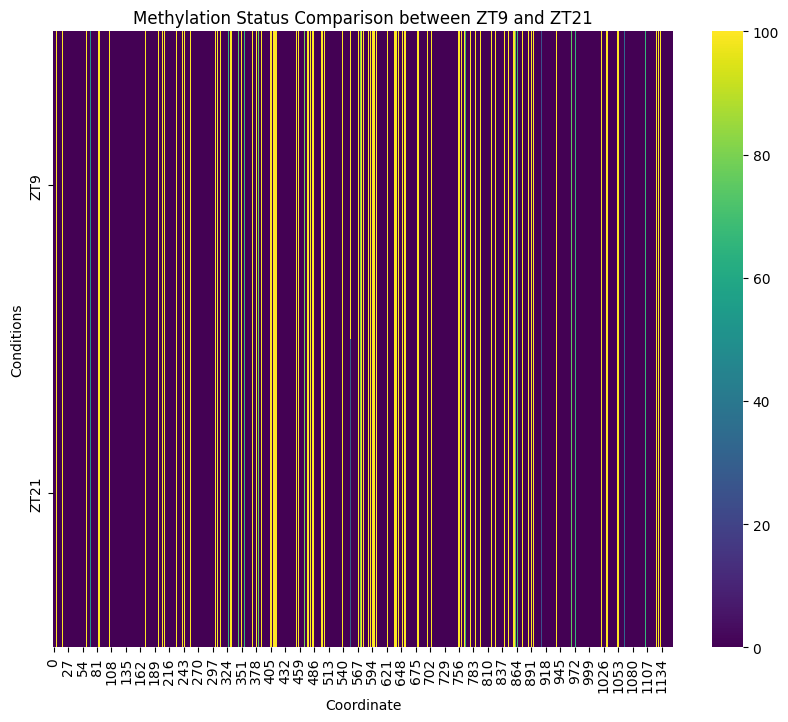

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path_zt9 = 'ZT9_1.bed'
file_path_zt21 = 'ZT21_1.bed'

# Read the files with the necessary columns (coordinates and methylation status)
cols_to_use = [1, 10]  # 0-based indexing for Python, hence column 2 is 1 and column 11 is 10
zt9_data = pd.read_csv(file_path_zt9, sep='\t', header=None, usecols=cols_to_use, names=['Coordinate', 'Methylation_ZT9'])
zt21_data = pd.read_csv(file_path_zt21, sep='\t', header=None, usecols=cols_to_use, names=['Coordinate', 'Methylation_ZT21'])

# Check the first few rows of the data to ensure it's loaded correctly
zt9_data.head(), zt21_data.head()

# Merge the datasets on the 'Coordinate' column
merged_data = pd.merge(zt9_data, zt21_data, on='Coordinate', how='outer')

# Replace NaNs with 0 to indicate no methylation at those positions
merged_data.fillna(0, inplace=True)

# Sort the data by coordinate to ensure a logical order in the heatmap
merged_data.sort_values(by='Coordinate', inplace=True)

# Display the first few rows of the merged dataset to verify the merge and sort
merged_data.head()

plt.figure(figsize=(10, 8))

# Heatmap to visualize the methylation status. 'Coordinate' will serve as the Y-axis, while the methylation status for ZT9 and ZT21 will be shown side by side.
sns.heatmap(merged_data.drop('Coordinate', axis=1).T, cmap="viridis", yticklabels=['ZT9', 'ZT21'])

# Adding labels and title for clarity
plt.title('Methylation Status Comparison between ZT9 and ZT21')
plt.xlabel('Coordinate')
plt.ylabel('Conditions')

plt.show()


arguably heatmaps of genomic regions are not useful visualtisations. Could just plot the regions where there is methylation

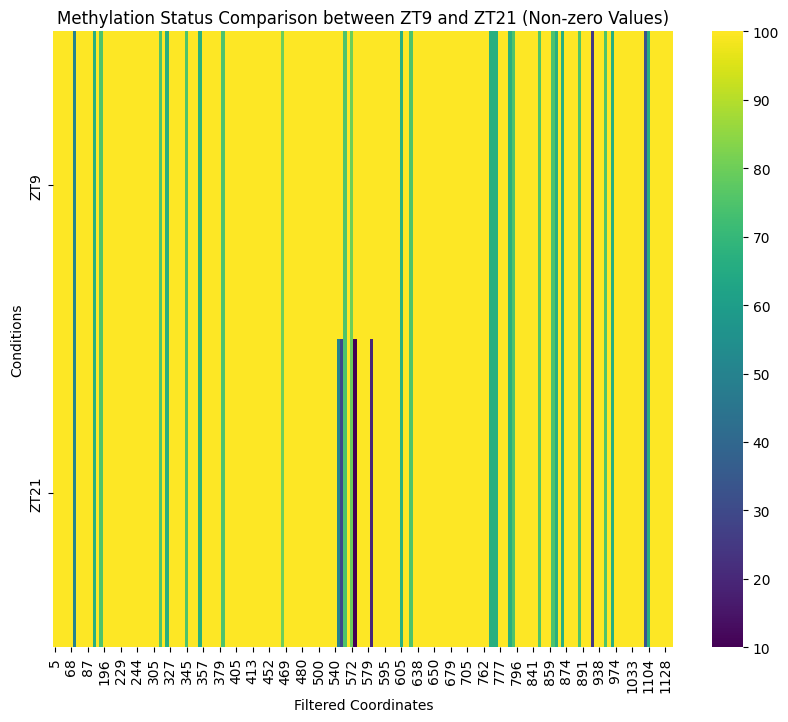

In [16]:
# Filter the merged dataset to keep only coordinates where at least one condition has a methylation value above 0
filtered_data = merged_data[(merged_data['Methylation_ZT9'] > 0) | (merged_data['Methylation_ZT21'] > 0)]

plt.figure(figsize=(10, 8))

# Plotting the filtered data as a heatmap
sns.heatmap(filtered_data.drop('Coordinate', axis=1).T, cmap="viridis", yticklabels=['ZT9', 'ZT21'])

# Adding labels and title for clarity
plt.title('Methylation Status Comparison between ZT9 and ZT21 (Non-zero Values)')
plt.xlabel('Filtered Coordinates')
plt.ylabel('Conditions')

plt.show()
